In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import numpy as np


# 데이터 전처리

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1.
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)


# 데이터 시각화

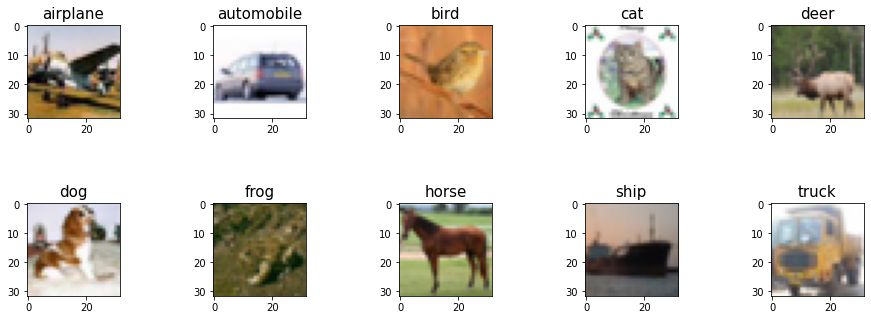

In [3]:

# CIFAR10 데이터셋의 클래스 이름
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in np.arange(0, 10):
    # 각 클래스에 해당하는 인덱스 찾기
    indices = np.where(np.argmax(y_train, axis=1) == i)[0]
    
    # 그 중 하나를 랜덤하게 선택하기
    idx = np.random.choice(indices)
    
    # 선택된 이미지 표시하기
    axes[i].imshow(x_train[idx])
    axes[i].set_title(class_names[i], fontsize=15)
    plt.subplots_adjust(wspace=1)


# 데이터 증강

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)


# 생성된 이미지를 시각화

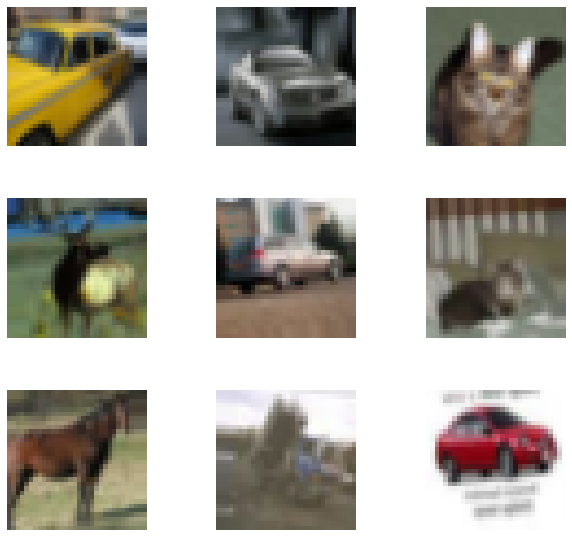

In [5]:
# 9개의 무작위 인덱스를 선택합니다.
indices = np.random.randint(0, x_train.shape[0], size=9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    # 선택된 인덱스에 해당하는 이미지를 가져옵니다.
    img = x_train[indices[i]:indices[i]+1]

    # 이 이미지에 대해 데이터 증강을 수행합니다.
    it = datagen.flow(img, batch_size=1)

    # 데이터 증강 기능을 통해 생성된 첫 번째 (즉 다음) 이미지를 가져옵니다.
    augmented_img = (it.next()[0]*255).astype('uint8')

    # 이미지 출력
    axes[i].imshow(augmented_img)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)



# 사전 훈련된 ResNet50 모델 로드

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False)

# The layers of the base model are not frozen and will be updated during training.

x = base_model.output

# Add a global spatial average pooling layer.
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer.
x = Dense(512, activation='relu')(x)

# Add a logistic layer with the number of classes in the CIFAR-10 dataset (in this case it's 10).
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



# 모델 컴파일

In [7]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 얼리스탑 콜백 정의

In [8]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델 학습

In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

train_generator = train_datagen.flow(x_train, y_train, batch_size=128)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history=model.fit(
          train_generator,
          steps_per_epoch=len(x_train) // 128,  # this should be number of batches per epoch
          epochs=100,
          validation_data=(x_test,y_test),
          callbacks=[early_stopping_callback])

Epoch 1/100
390/390 [==============================] - 31s 79ms/step - loss: 0.6637 - accuracy: 0.7689 - val_loss: 0.6555 - val_accuracy: 0.7774
Epoch 2/100
390/390 [==============================] - 29s 76ms/step - loss: 0.5880 - accuracy: 0.7941 - val_loss: 0.6495 - val_accuracy: 0.7814
Epoch 3/100
390/390 [==============================] - 29s 75ms/step - loss: 0.5282 - accuracy: 0.8140 - val_loss: 0.5933 - val_accuracy: 0.7995
Epoch 4/100
390/390 [==============================] - 29s 75ms/step - loss: 0.4859 - accuracy: 0.8295 - val_loss: 0.6094 - val_accuracy: 0.7962
Epoch 5/100
390/390 [==============================] - 29s 75ms/step - loss: 0.4510 - accuracy: 0.8423 - val_loss: 0.5700 - val_accuracy: 0.8118
Epoch 6/100
390/390 [==============================] - 30s 76ms/step - loss: 0.4152 - accuracy: 0.8548 - val_loss: 0.6306 - val_accuracy: 0.7971
Epoch 7/100
390/390 [==============================] - 29s 75ms/step - loss: 0.3874 - accuracy: 0.8628 - val_loss: 0.5965 - val_ac

# 평가

In [12]:
score = model.evaluate(x_test, y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 15ms/step - loss: 0.5968 - accuracy: 0.8362
Test loss: 0.5967517495155334
Test accuracy: 0.8361999988555908


# 학습 과정 시각화

Test Loss: 0.5967517495155334 Test Accuracy: 0.8361999988555908


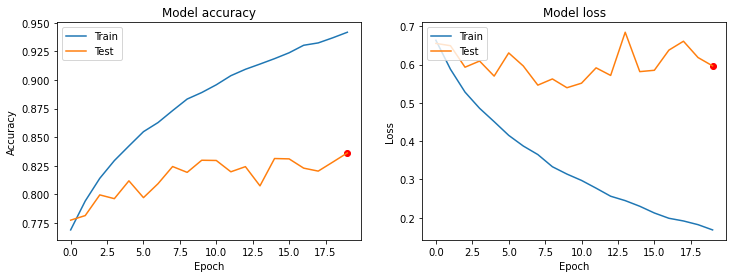

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# Mark the test accuracy on the graph
plt.scatter(len(history.history['accuracy'])-1, score[1], color='red')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# Mark the test loss on the graph
plt.scatter(len(history.history['loss'])-1, score[0], color='red')

# Show the plot
print(f'Test Loss: {score[0]} Test Accuracy: {score[1]}') # prints out final scores 
